https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa


In [10]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200

nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [12]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


# Build a skip-gram [(target, context), relevancy] generator

For this, we feed our skip-gram model pairs of (X, Y) where X is our input and Y is our label. We do this by using [(target, context), 1] pairs as positive input samples where target is our word of interest and context is a context word occurring near the target word and the positive label 1 indicates this is a contextually relevant pair. We also feed in [(target, random), 0] pairs as negative input samples where target is again our word of interest but random is just a randomly selected word from our vocabulary which has no context or association with our target word. Hence the negative label 0 indicates this is a contextually irrelevant pair. We do this so that the model can then learn which pairs of words are contextually relevant and which are not and generate similar embeddings for semantically similar words.

In [14]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(bible (5766), james (1154)) -> 1
(james (1154), rohgah (9806)) -> 0
(bible (5766), korahite (9872)) -> 0
(king (13), eber (2798)) -> 0
(james (1154), bible (5766)) -> 1
(king (13), bible (5766)) -> 1
(king (13), james (1154)) -> 1
(bible (5766), king (13)) -> 1
(james (1154), amends (8715)) -> 0
(james (1154), king (13)) -> 1


In [15]:
len(skip_grams)

29251

In [16]:
skip_grams[0]

([[5766, 1154],
  [1154, 9806],
  [5766, 9872],
  [13, 2798],
  [1154, 5766],
  [13, 5766],
  [13, 1154],
  [5766, 13],
  [1154, 8715],
  [1154, 13],
  [13, 4529],
  [5766, 8840]],
 [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0])

# Building the skip-gram model architecture

 For this our inputs will be our target word and context or random word pair. Each of which are passed to an embedding layer (initialized with random weights) of it’s own. Once we obtain the word embeddings for the target and the context word, we pass it to a merge layer where we compute the dot product of these two vectors. Then we pass on this dot product value to a dense sigmoid layer which predicts either a 1 or a 0 depending on if the pair of words are contextually relevant or just random words (Y’). We match this with the actual relevance label (Y), compute the loss by leveraging the mean_squared_error loss and perform backpropagation with each epoch to update the embedding layer in the process. Following code shows us our model architecture.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 1, 100)            1242500   
_________________________________________________________________
reshape_47 (Reshape)         (None, 100)               0         
Total params: 1,242,500
Trainable params: 1,242,500
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 1)            0                                            
_________________________________

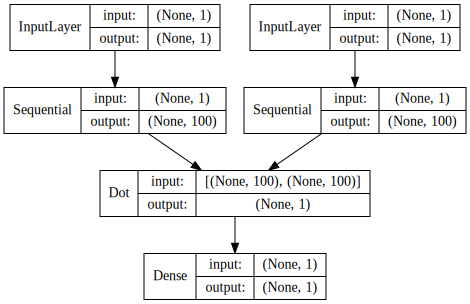

In [45]:
from keras.layers import dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.models import Model

input_1 = Input(shape=(1,))
input_2 = Input(shape=(1,))

# build skip-gram architecture
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))
word_model.summary()

out1 = word_model(input_1)


context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

out2 = context_model(input_2)

x = dot([out1, out2], axes=1)
x = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(x)

model =  Model(inputs=[input_1, input_2], outputs=x)
model.compile(loss="mean_squared_error", optimizer="rmsprop")

model.summary()


# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                  rankdir='TB').create(prog='dot', format='svg'))

In [46]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs


W0710 06:13:51.172223 139832561526656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0710 06:13:51.204910 139832561526656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 4531.9908620379865
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3767.3675716863945
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 3753.8449253009167
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 3804.7816245462163
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 3742.432873359561


# Get Word Embeddings

In [51]:
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(12425, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
shall,-0.012422,-0.020036,-0.017483,-0.013122,0.010576,-0.007503,0.011215,0.007315,0.000338,-0.017951,-0.016464,0.000867,0.006184,-0.020151,-0.005745,-0.010562,-0.017033,-0.003692,-0.016533,-0.005889,-0.008186,0.014368,0.008513,-0.008814,0.002228,-0.018742,0.009084,0.004849,0.005718,0.009122,0.015850,-0.013275,-0.000635,-0.005764,-0.006347,0.012258,0.007591,0.000951,0.019806,0.010275,...,0.017121,-0.008911,0.013081,-0.000067,0.016754,-0.014832,-0.007994,-0.017931,-0.010790,0.004147,-0.008141,-0.011672,0.012713,-0.018913,0.018869,0.010652,-0.018133,0.020519,-0.015392,-0.006466,0.003543,-0.010969,-0.014942,-0.020452,-0.011605,0.020499,0.009112,0.003567,0.019239,0.011071,-0.008868,0.007840,0.006471,-0.010983,0.000358,-0.011551,-0.008325,-0.017947,-0.004696,0.018255
unto,0.034100,0.180420,-0.441217,0.037462,0.127804,0.032331,0.003542,-0.043264,0.039325,0.041041,-0.110801,-0.199340,-0.045121,-0.110810,-0.057338,0.023514,-0.044591,-0.002689,0.013096,-0.100149,0.155493,-0.002136,-0.168873,-0.059107,-0.099961,-0.032566,-0.174667,-0.046394,-0.039652,0.033117,-0.005316,-0.027812,-0.158080,-0.005536,-0.143310,-0.158454,-0.065740,0.038800,0.039770,-0.016265,...,0.009764,-0.124887,-0.099747,-0.014948,-0.092568,0.160481,-0.191145,-0.069600,-0.225256,0.044475,-0.045760,0.012984,0.089087,0.123042,-0.064627,0.190248,-0.130555,-0.344315,0.007837,0.027703,0.152754,-0.004223,0.154084,-0.123652,0.039304,-0.010693,0.278337,-0.058895,-0.089672,0.030795,0.103642,0.192906,-0.010108,-0.112736,-0.078267,0.087188,0.062247,0.254126,-0.141179,-0.051032
lord,0.061889,0.077935,-0.281119,0.008736,0.044355,0.013745,0.136037,-0.018273,0.067286,0.224294,-0.003325,-0.098153,-0.028425,-0.161629,-0.064775,0.163440,-0.097830,-0.040454,-0.032482,0.013378,-0.001417,0.001955,-0.011842,-0.054225,-0.062158,-0.027082,-0.411419,-0.018333,-0.014946,0.048303,-0.014260,0.033983,-0.049177,0.112251,0.115364,0.008551,-0.045735,0.167213,0.096660,0.029182,...,0.031148,0.023146,-0.048519,0.021851,-0.131256,0.002964,-0.011669,0.001671,-0.187086,-0.034647,-0.220000,0.015831,0.085446,0.026685,-0.022796,-0.057739,0.122991,-0.283213,0.080222,-0.095072,0.097093,-0.009105,0.027330,0.033144,-0.022108,0.007612,0.198059,0.069299,-0.249739,-0.055430,-0.129567,0.097200,0.083280,-0.052149,-0.106127,-0.078064,-0.113166,0.215920,-0.139021,-0.034943
thou,0.090094,0.344583,-0.355620,0.106176,-0.029886,-0.012042,-0.016372,0.032659,0.195226,0.013223,0.026530,-0.074357,-0.119079,-0.072989,-0.058612,0.117646,-0.111835,-0.033928,-0.009969,-0.159031,-0.060775,-0.020605,-0.125407,-0.177898,0.037218,-0.081958,-0.220567,0.004148,-0.064559,-0.014126,-0.013032,0.151565,-0.232864,0.082738,0.053368,-0.141257,-0.159900,0.202295,0.072843,0.088620,...,0.049397,-0.014007,0.045505,0.096238,-0.059895,0.058028,-0.049784,-0.083291,-0.023573,0.036988,-0.024366,-0.035928,0.034990,0.097629,-0.153647,0.016012,-0.023025,-0.134979,0.030312,-0.152775,0.123341,-0.002578,0.089710,-0.079110,0.015033,0.017928,0.075198,-0.040014,-0.094308,0.114139,-0.018035,0.090245,0.075862,-0.001541,0.000673,-0.153127,0.026079,0.185531,-0.040391,0.029416
thy,0.078411,0.065561,-0.414808,0.023220,-0.113078,0.038957,0.091203,-0.227318,0.054084,0.022882,-0.029323,-0.076458,0.036480,-0.019148,-0.254878,0.058988,-0.073930,0.011486,-0.125697,-0.042732,-0.054411,0.001128,-0.289262,-0.009530,0.080376,-0.047801,-0.300094,0.076672,-0.034164,0.113948,-0.026071,0.051913,-0.045160,0.035580,-0.020676,-0.140302,-0.098480,0.160988,-0.029239,0.012719,...,0.041800,-0.023576,0.012160,0.018446,-0.267084,0.100041,-0.003852,-0.042449,-0.156670,-0.141122,-0.034390,-0.110718,0.045714,0.132798,0.096027,0.151834,0.057732,-0.192624,0.102324,0.064853,0.351041,-0.014989,0.006020,-0.014475,0.016563,0.073243,-0.087481,-0.057189,-0.027418,0.075946

In [53]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['good', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12425, 12425)


{'egypt': ['aaron', 'servant', 'dwell', 'life', 'tell'],
 'famine': ['esther', 'age', 'evermore', 'wept', 'armies'],
 'good': ['anger', 'inhabitants', 'sight', 'servant', 'twenty'],
 'gospel': ['gibeon', 'azariah', 'roar', 'carcases', 'joyful'],
 'jesus': ['give', 'sight', 'christ', 'daughter', 'serve'],
 'john': ['fled', 'except', 'false', 'gibeon', 'seventy'],
 'moses': ['toward', 'door', 'began', 'help', 'nations'],
 'noah': ['nathan', 'merchandise', 'insomuch', 'corruption', 'excess']}